# Выбор региона для миграции семьи

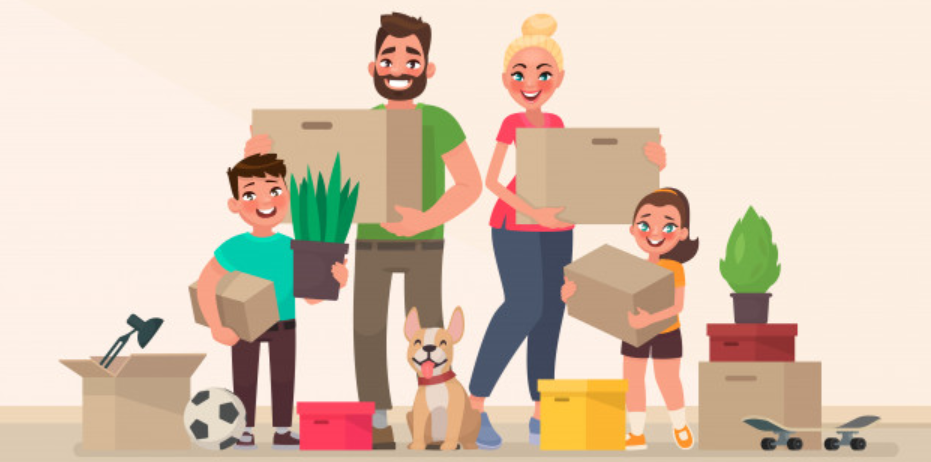

In [459]:
# БИБЛИОТЕКИ

import re
import numpy as np
import pandas as pd

from tabulate import tabulate 
from IPython.display import HTML, display



pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок
import warnings; warnings.simplefilter('ignore') #  отключение вывода предупреждающих сообщений


# ФУНКЦИИ



# Код, позволяющий скрывать ячейки
from IPython.display import HTML
import random

def hide_toggle(toggle_text = 'Toggle show/hide', for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

#    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle('Блок функций и библиотек')


### Мероприятия по подготовке данных к исследованию

При работе со статистическими данными, касающимися регионов и субъектов федерации, приходится решать проблему несоответствия наименований объектов, используемых в различных источниках.

В целях стандартизации перечня наименований произведем его приведение к Списоку регионов России в порядке заполнения формы РСВ (Приложение № 7).
Для этого сократим используемые наименования устранив упоминание о форме административного образования (область, край и т.д.)


In [552]:
# Стандартизация наименований субъектов федерации

xls = pd.ExcelFile('codeSF.xlsx')
sf_code = pd.read_excel(xls, 'Sheet1')
sf_code.dropna(axis = 0, inplace = True)

def standardization_name(df, original_name, small_name):
    pattern = '[Городг.Республика]*\s*([\w\-]+)'
    df[small_name] = df[original_name].apply(lambda x: re.findall(pattern, x.strip())[0])
    return df
    
sf_code = standardization_name(sf_code, 'Наименование', 'sm_name')

## Доходы и расходы населения



In [553]:
# Смотрим на доходы

xls = pd.ExcelFile('Revenue.xlsx')
revenue = pd.read_excel(xls, '2013-2018',header = 3)
revenue = revenue.dropna(how = 'all', axis = 0, thresh = 30)

revenue19 = pd.read_excel(xls, '2019',header = 2)
revenue19 = revenue19.dropna(how = 'all', axis = 0, thresh = 11)
revenue19 = revenue19.dropna(axis = 1)
revenue = pd.merge(revenue, revenue19, on = ['Unnamed: 0'])
revenue = pd.DataFrame(np.rot90(np.array(revenue).T, 3))
revenue = revenue[revenue.columns.to_list()[::-1]]
column_list = ['name']
m = 1
y = 2013
for i in revenue.columns.to_list()[1:]:
    column_list.append(str(y) + '-' + str(m).zfill(2))
    m += 1
    if m == 13:
        m = 1
        y += 1
revenue.columns = column_list

matrix = pd.DataFrame(revenue['name'])

for y in range(2013, 2019+1):
    temp_column_list = ['name']
    for c in column_list:
        if str(y) in c:
            temp_column_list.append(c)
    df = revenue[temp_column_list]
    res = []
    for s in np.array(df):
        res.append(round(np.median(s[1:]), 2))
    matrix[str(y)] = res
matrix['revenue17'] = matrix['2017'].apply(lambda x: x*2)
matrix['revenue19'] = matrix['2019'].apply(lambda x: x*2)
revenue = standardization_name(matrix, 'name', 'sm_name')
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
name         96 non-null object
2013         94 non-null float64
2014         94 non-null float64
2015         96 non-null float64
2016         96 non-null float64
2017         96 non-null float64
2018         96 non-null float64
2019         96 non-null float64
revenue17    96 non-null float64
revenue19    96 non-null float64
sm_name      96 non-null object
dtypes: float64(9), object(2)
memory usage: 8.4+ KB


In [554]:
# Исследуем данные о прожиточном минимуме

xls = pd.ExcelFile('Coasts.xls')
coast17 = pd.read_excel(xls, 'Данные',header = 4)
coast17 = coast17.dropna(how = 'all', axis = 0, thresh = 5)
coast17.rename(columns = lambda x: x.replace('Unnamed: 0', 'name'), inplace=True)
coast17['chil'] = coast17.apply(lambda x: [x['Дети'], x['Дети.1'], x['Дети.2'], x['Дети.2']], axis = 1)
coast17['chil'] = coast17['chil'].map(lambda x: np.median(x))
coast17['work'] = coast17.apply(lambda x: [x['Трудоспособное население'], x['Трудоспособное население.1'],
                                         x['Трудоспособное население.2'], x['Трудоспособное население.2']], axis = 1)
coast17['work'] = coast17['work'].map(lambda x: np.median(x))
coast17['coast17'] = coast17.apply(lambda x: x['work']*2 + x['chil']*2, axis = 1)
coast17['name'] = coast17['name'].apply(lambda x: x.replace('федерального значения ',''))
coast17 = coast17[['name', 'coast17']]
coast17 = standardization_name(coast17, 'name', 'sm_name')

xls = pd.ExcelFile('vpm.xlsx')
coast19 = pd.read_excel(xls, 'Sheet1',header = 2)
coast19.rename(columns = lambda x: x.replace('Unnamed: 0', 'name'), inplace=True)
coast19 = coast19.dropna(how = 'all', axis = 0, thresh = 3)
coast19['coast19'] = coast19.apply(lambda x: x['трудоспособное население']*2 + x['дети']*2, axis = 1)
coast19['name'] = coast19['name'].apply(lambda x: x.replace('авт.область','автономная область')
                                                    .replace('авт.округ','автономный округ'))
coast19 = coast19[['name', 'coast19']]
coast19 = standardization_name(coast19, 'name', 'sm_name')

coasts = pd.merge(sf_code, coast17, how = 'left', on = ['sm_name'])
coasts = pd.merge(coasts, coast19, how = 'left', on = ['sm_name'])
columns = ['Код', 'coast17', 'coast19', 'sm_name']
coasts = coasts[columns]

coasts['coast17'] = coasts['coast17'].apply(lambda x: None if x == 0 else x)
coasts['coast19'] = coasts['coast19'].apply(lambda x: None if x == 0 or '-' in str(x) else x)
coasts.dropna(axis = 0, inplace = True)
coasts['delta_coast'] = coasts.apply(lambda x: round((x['coast19'] - x['coast17']) / x['coast17'] * 100, 2), axis = 1)
coasts = coasts.sort_values(by = ['coast19'], ascending = False)
coasts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 87 to 33
Data columns (total 5 columns):
Код            83 non-null float64
coast17        83 non-null float64
coast19        83 non-null float64
sm_name        83 non-null object
delta_coast    83 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


In [555]:
# Формируем сравнение покупательской способности по регионам

matrix = pd.merge(revenue, coasts, how = 'left', on = ['sm_name'])
#matrix.drop(['Код', 'sm_name'], axis=1, inplace = True)
matrix['real_revenue17'] = matrix.apply(lambda x: x['revenue17'] / x['coast17'], axis = 1)
matrix['real_revenue19'] = matrix.apply(lambda x: round(x['revenue19'] / x['coast19'], 2), axis = 1)

matrix['delta_real_rev'] = matrix.apply(lambda x: round((x['real_revenue19'] - x['real_revenue17']) / x['real_revenue17'] * 100, 2), axis = 1)
matrix['delta_real_rev'] = matrix['delta_real_rev'].map(lambda x: '+' + str(x) + '%' if x >= 0 else str(x) + '%')

key_columns = ['Код', 'name', 'revenue19', 'coast19', 'real_revenue19', 'delta_real_rev']
matrix_dis = matrix.sort_values(by = ['real_revenue19'], ascending = False)
display(HTML(tabulate(np.array(matrix_dis[key_columns].dropna(axis = 0)), headers = key_columns, tablefmt='html', showindex="always")))
matrix.info(verbose = False)

,Код,name,revenue19,coast19,real_revenue19,delta_real_rev
0,72,Тюменская область,138690,47402,2.93,+6.01%
1,89,Ямало-Ненецкий авт. округ,192782,68814,2.8,+6.54%
2,65,Сахалинская область,169186,63832,2.65,+13.9%
3,77,г.Москва,178090,67996,2.62,+20.66%
4,78,г.Санкт-Петербург,122282,47520,2.57,+7.28%
5,87,Чукотский авт.округ,208717,92708,2.25,+1.39%
6,49,Магаданская область,176085,83752,2.1,+8.27%
7,50,Московская область,108197,51924,2.08,+13.92%
8,47,Ленинградская область,90737,44050,2.06,+3.94%
9,14,Республика Саха (Якутия),139651,70828,1.97,+14.92%


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Columns: 18 entries, name to delta_real_rev
dtypes: float64(15), object(3)
memory usage: 14.2+ KB


В представленной таблице:
* __name__ - наименование субъекта федерации
* __revenue19__ - средний доход семьи с двумя работающими родителями, 2019 год
* __coast19__ - прожиточный минимум для семьи, состоящей из двух взрослых и двух детей, 2019 г.
* __real_revenue19__ - покупательская способность семьи, рассчитанная как частное средних доходов семьи к ее среднему прожиточному минимуму, 2019 г.
* __delta_real_rev__ - изменение покупательской способности семьи, произошедшее в период с 2017 по 2019 гг.

Таблица отсортирована по покупательской способности.

In [556]:
# Произведем оценку численности населения по состояния на 1 января 2019 года.

xls = pd.ExcelFile('Population.xlsx')
people = pd.read_excel(xls, 'Sheet1',header = 2)
people.rename(columns = lambda x: x.replace('Unnamed: 0', 'name').replace('Все', 'people'), inplace=True)
people = standardization_name(people[['name', 'people']], 'name', 'sm_name')
matrix = pd.merge(matrix, people.drop(['name'], axis = 1), how = 'left', on = ['sm_name'])
matrix = matrix.drop_duplicates(subset = ['sm_name', 'real_revenue19'], keep='first')

print('ДОБАВЛЕНЫ СТОЛБЦЫ:')
people.drop(['name', 'sm_name'], axis = 1).info()
print('\nВ МАТРИЦЕ:')
matrix.info(verbose = False)

ДОБАВЛЕНЫ СТОЛБЦЫ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 1 columns):
people    96 non-null int64
dtypes: int64(1)
memory usage: 896.0 bytes

В МАТРИЦЕ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 99
Columns: 19 entries, name to people
dtypes: float64(16), object(3)
memory usage: 15.0+ KB


In [557]:
# Разберем статистику ВУЗов

xls = pd.ExcelFile('High_scool.xls')
high_school = pd.read_excel(xls, 'Таблица 1', header = 6)
high_school = high_school.dropna(how = 'all', axis = 0, thresh = 15)

high_school.rename(columns = lambda x: str(x).replace('1', 'name')
                   .replace('2', 'school')
                   .replace('6', 'school_f')
                   .replace('7', 'students') if len(str(x)) == 1 else x, inplace=True)
new_column = []
for i in high_school.columns.to_list():
    new_column.append(str(i))
high_school.columns = new_column   

high_school = standardization_name(high_school, 'name', 'sm_name')
high_school = pd.merge(high_school, people.drop(['name'], axis = 1), how = 'left', on = ['sm_name'])

high_school['share_stud_people']  = high_school.apply(lambda x: x['students'] / x['people'] * 100, axis = 1)
high_school['share_full_stud']    = high_school.apply(lambda x: x['8'] / x['students'] * 100 if x['students'] != 0 else None, axis = 1)
high_school['share_evening_stud'] = high_school.apply(lambda x: x['9'] / x['students'] * 100 if x['students'] != 0 else None, axis = 1)
high_school['share_corr_stud']    = high_school.apply(lambda x: x['10'] / x['students'] * 100 if x['students'] != 0 else None, axis = 1)
high_school.rename(columns = lambda x: str(x).replace('13', 'share_stud_femail'), inplace=True)
high_school['growth_stud']        = high_school.apply(lambda x: (x['16'] - x['20']) / x['20'] * 100 if x['20'] != 0 else None, axis = 1)
high_school['screening_out_stud'] = high_school.apply(lambda x: (x['16'] - x['20']) / x['16'] * 100 if x['16'] != 0 else None, axis = 1)
high_school['share_extern_stud']  = high_school.apply(lambda x: x['24'] / x['20'] * 100 if x['20'] != 0 else None, axis = 1)
high_school = high_school[['name', 'sm_name', 'school', 'school_f', 'students', 'share_stud_people'
                           , 'share_full_stud', 'share_evening_stud', 'share_corr_stud', 'share_stud_femail'
                           , 'growth_stud', 'screening_out_stud', 'share_extern_stud']]

matrix = pd.merge(matrix, high_school.drop(['name'], axis = 1), how = 'left', on = ['sm_name'])
matrix = matrix.drop_duplicates(subset = ['name', 'real_revenue19'], keep='first')

print('ДОБАВЛЕНЫ СТОЛБЦЫ:')
high_school.drop(['name', 'sm_name'], axis = 1).info()
print('\nВ МАТРИЦЕ:')
matrix.info(verbose = False)

ДОБАВЛЕНЫ СТОЛБЦЫ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 11 columns):
school                96 non-null int64
school_f              96 non-null int64
students              96 non-null int64
share_stud_people     95 non-null float64
share_full_stud       95 non-null float64
share_evening_stud    95 non-null float64
share_corr_stud       95 non-null float64
share_stud_femail     96 non-null float64
growth_stud           95 non-null float64
screening_out_stud    95 non-null float64
share_extern_stud     95 non-null float64
dtypes: float64(8), int64(3)
memory usage: 9.0 KB

В МАТРИЦЕ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 99
Columns: 30 entries, name to share_extern_stud
dtypes: float64(27), object(3)
memory usage: 23.2+ KB


In [558]:
# Проведем оценку численности преподавательского состава
xls = pd.ExcelFile('Professors.xls')
teachers = pd.read_excel(xls, 'Таблица 1', header = 6)

teachers.rename(columns = lambda x: str(x).replace('11', 'share_mag_teach')
                    .replace('1', 'name')
                    .replace('2', 'teachers')
                    .replace('9', 'share_doc_teach'), inplace=True)

teachers = standardization_name(teachers[['name', 'teachers', 'share_doc_teach', 'share_mag_teach']], 'name', 'sm_name')
teachers = pd.merge(teachers, matrix[['sm_name', 'students']], how = 'left', on = ['sm_name'])

teachers['share_teach_stud'] = teachers.apply(lambda x: x['teachers'] / x['students'] * 100, axis = 1)
teachers = teachers[['sm_name', 'teachers', 'share_teach_stud', 'share_doc_teach', 'share_mag_teach']]

# Добавим полученные данные к матрице
matrix = pd.merge(matrix, teachers, how = 'left', on = ['sm_name'])
matrix = matrix.drop_duplicates(subset = ['name', 'real_revenue19'], keep='first')

print('ДОБАВЛЕНЫ СТОЛБЦЫ:')
teachers.drop(['sm_name'], axis = 1).info()
print('\nВ МАТРИЦЕ:')
matrix.info(verbose = False)

ДОБАВЛЕНЫ СТОЛБЦЫ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 4 columns):
teachers            96 non-null int64
share_teach_stud    95 non-null float64
share_doc_teach     96 non-null float64
share_mag_teach     96 non-null float64
dtypes: float64(3), int64(1)
memory usage: 3.8 KB

В МАТРИЦЕ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 99
Columns: 34 entries, name to share_mag_teach
dtypes: float64(31), object(3)
memory usage: 26.2+ KB


In [559]:
# Средний возраст преподавателей

xls = pd.ExcelFile('Professors_age.xls')
teachers_age = pd.read_excel(xls, 'Таблица 1', header = 5)

vector_age = np.array([22,25,30,35,40,45,50,55,60,65,70])

teachers_age.rename(columns = lambda x: str(x).replace('1', 'name'), inplace=True)
teachers_age = standardization_name(teachers_age, 'name', 'sm_name')
teachers_age = pd.merge(matrix[['sm_name']], teachers_age, how = 'left', on = ['sm_name'])
teachers_age = teachers_age.fillna(0)

teachers_age.drop(['name', 'sm_name'], inplace = True, axis = 1)
v_teachers_age = np.array(teachers_age)
v_teachers_age = np.around(v_teachers_age)

# Расчет среднего возраста преподавателей
matrix_age = v_teachers_age * vector_age[:-1]
avg_teach_age = []
for a in matrix_age:
    avg_teach_age.append(np.around(sum(a)/100, decimals = 1))
    
matrix['teacher_age_avg'] = avg_teach_age

# Рассчет медианных значений возраста преподавателей
period_age = (vector_age[1:] - vector_age[:-1]) / v_teachers_age
median_age = []
for indexS, s in enumerate(v_teachers_age):
    str_median_age = []
    for indexC, c in enumerate(s):
        for i in range(int(c)):
            str_median_age.append(vector_age_min[indexC] + i * period_age[indexS][indexC])
    median_age.append(np.median(str_median_age))
median_age = np.around(median_age, decimals = 1)

matrix['teacher_age_median'] = median_age
matrix = matrix.drop_duplicates(subset = ['name', 'real_revenue19'], keep='first')


print('ДОБАВЛЕНЫ СТОЛБЦЫ\nteacher_age_avg\nteacher_age_median \n\nВ МАТРИЦЕ:')
matrix.info(verbose = False)

ДОБАВЛЕНЫ СТОЛБЦЫ
teacher_age_avg
teacher_age_median 

В МАТРИЦЕ:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 99
Columns: 36 entries, name to teacher_age_median
dtypes: float64(33), object(3)
memory usage: 27.8+ KB


In [560]:
display(HTML(tabulate(np.array(matrix), tablefmt='html', showindex="always")))
matrix.info()

0,Российская Федерация,29874.5,32355.5,33351.9,35865.6,38202.9,42388.5,46324.2,76405.8,92648.4,йская,nan,nan,nan,nan,nan,nan,nan%,1.46749e+08,724,563,4.06833e+06,2.77231,58.6624,4.46073,36.8769,53,24.2929,19.5449,0.779512,229334,5.63706,15.8,58,48.2,49.2
1,Центральный федеральный округ,35877.8,39744.4,40959.3,44957.6,47097.5,52850,58523.2,94195.1,117046,Центральный,nan,nan,nan,nan,nan,nan,nan%,3.94336e+07,262,131,1.26851e+06,3.21683,60.4148,6.26925,33.3159,52.8,19.4388,16.2751,1.31806,76668,6.04394,17.5,56.1,47.8,50.6
2,Белгородская область,22088.3,23691,25138.2,26694.8,28668,31328.5,33948.7,57336,67897.4,Белгородская,31,34457,38246,11,1.66399,1.78,+6.97%,1.54915e+06,5,6,46787,3.02017,50.2917,1.46836,48.2399,47.7,17.287,14.7391,1.53492,2313,4.94368,14.7,61.4,44.4,45
3,Брянская область,19116,20811.2,21372.8,22570.9,24016,26891.9,29262.1,48032.1,58524.2,Брянская,32,40094,44654,11.37,1.19799,1.31,+9.35%,1.19249e+06,5,5,23737,1.99054,45.9325,5.02591,49.0416,46.6,6.69586,6.27565,0,1003,4.22547,14.4,68.5,45.6,45.5
4,Владимирская область,20194.4,22142,23558.7,25567.5,27593.1,31427.5,31298.5,55186.1,62597,Владимирская,33,40650,45052,10.83,1.35759,1.39,+2.39%,1.35842e+06,3,6,26397,1.94322,42.7018,7.20158,50.0966,50.7,21.7471,17.8625,0,1188,4.50051,13.4,60.9,47.6,49.7
5,Воронежская область,22025.4,24055.2,24895.3,26568.2,28089.6,31126.4,32905.6,56179.2,65811.2,Воронежская,36,35390,38660,9.24,1.58743,1.7,+7.09%,2.32420e+06,15,9,85071,3.66022,57.0277,1.41294,41.5594,51.9,15.9542,13.759,1.27851,4705,5.53067,17.1,59.1,47,47.7
6,Ивановская область,18378.2,20127,20681.8,21578.7,22851.9,25070.9,26454.6,45703.7,52909.2,Ивановская,37,42031,43680,3.92,1.08738,1.21,+11.28%,997135,6,5,24656,2.47268,60.6343,4.51817,34.8475,48.7,21.6018,17.7644,0,1601,6.49335,17.7,62.6,48.9,50.5
7,Калужская область,25336.5,27859.4,28879,31198.2,33564,37351.2,40334.7,67128.1,80669.4,Калужская,40,40624,45512,12.03,1.65242,1.77,+7.12%,1.00258e+06,3,9,18588,1.85403,56.3159,4.21777,39.4663,56.1,47.8431,32.3607,0,844,4.54056,10.7,64.3,47.8,51.2
8,Костромская область,18842.8,20730.5,21443.3,22841.9,24048.1,27200.1,29926.5,48096.2,59853,Костромская,44,40536,44054,8.68,1.18651,1.36,+14.62%,633385,2,0,10247,1.61782,54.0061,4.61599,41.378,55,13.0128,11.5144,0,566,5.52357,12.9,62.4,47.4,49.6
9,Курская область,20782,23075.6,23529,25079.7,27088.1,29497.5,32235.8,54176.2,64471.6,Курская,46,36792,42068,14.34,1.4725,1.53,+3.9%,1.10401e+06,8,3,36373,3.29463,51.8132,1.59184,46.595,57.3,3.43008,3.31633,0.0344155,1755,4.82501,17.9,63.6,44.6,45.5
10,Липецкая область,21108,23046.8,23737,25404.9,28019.4,31196.8,33757.5,56038.7,67515,Липецкая,48,36482,40710,11.59,1.53607,1.66,+8.07%,1.13937e+06,4,7,20204,1.77326,50.4257,12.4975,37.0768,56.6,6.29186,5.91942,0,948,4.69214,12.2,66.6,46.6,47.3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 99
Data columns (total 36 columns):
name                  96 non-null object
2013                  94 non-null float64
2014                  94 non-null float64
2015                  96 non-null float64
2016                  96 non-null float64
2017                  96 non-null float64
2018                  96 non-null float64
2019                  96 non-null float64
revenue17             96 non-null float64
revenue19             96 non-null float64
sm_name               96 non-null object
Код                   85 non-null float64
coast17               85 non-null float64
coast19               85 non-null float64
delta_coast           85 non-null float64
real_revenue17        85 non-null float64
real_revenue19        85 non-null float64
delta_real_rev        96 non-null object
people                94 non-null float64
school                95 non-null float64
school_f              95 non-null float64
students          